In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
df = pd.read_csv('./NewData/Coillabeled.csv')
X=df.drop(columns=['label', 'Thickness profile', 'furnace Number'])
y=df['label']
 

# Data  Preprocessing

In [85]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X ,y, stratify=y, train_size=0.8, random_state=42)

In [86]:
### This is the piece of code that downsamples the majority class.
### It uses the resample() from sklearn.utils


from sklearn.utils import resample

df_new = X_train.join(y_train)
df_constrict = df_new[df_new['label']==1]
df_no_constrict = df_new[df_new['label']==0]

# If one wants to undersample, one can uncomment this piece of code and comment the last 2 lines
#df_undersample = resample(df_no_constrict, replace=True, n_samples=len(df_constrict))
#df_balanced = pd.concat([df_undersample, df_constrict])

df_upsample = resample(df_constrict, replace=True, n_samples=len(df_no_constrict), random_state=42)
df_balanced = pd.concat([df_upsample, df_no_constrict])

 

In [89]:
X_balanced = df_balanced.drop(columns=['label'])
y_balanced = df_balanced['label']

# ML-models

In [215]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def metrics(model):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot()
    print(classification_report(y_test,y_pred))

### A very simple Desicion tree

In [185]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(max_depth=2,random_state=42)
dtc.fit(X_balanced, y_balanced)

train_score = dtc.score(X_balanced, y_balanced)
test_score = dtc.score(X_test, y_test)

print(f'train score: {train_score}')
print(f'test score: {test_score}')

train score: 0.7530207058072071
test score: 0.8832116788321168


              precision    recall  f1-score   support

           0       0.98      0.90      0.94      4697
           1       0.23      0.62      0.33       235

    accuracy                           0.88      4932
   macro avg       0.60      0.76      0.64      4932
weighted avg       0.94      0.88      0.91      4932



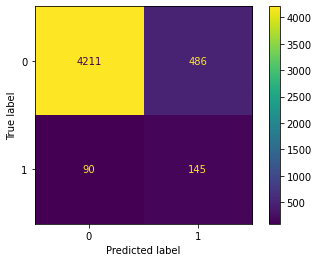

In [216]:
metrics(dtc)

[Text(0.5, 0.8333333333333334, 'X[6] <= 553.5\ngini = 0.5\nsamples = 37574\nvalue = [18787, 18787]'),
 Text(0.25, 0.5, 'X[5] <= 3.365\ngini = 0.474\nsamples = 29771\nvalue = [11513, 18258]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.248\nsamples = 13283\nvalue = [1931, 11352]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.487\nsamples = 16488\nvalue = [9582, 6906]'),
 Text(0.75, 0.5, 'X[1] <= 144.5\ngini = 0.126\nsamples = 7803\nvalue = [7274, 529]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.104\nsamples = 7671\nvalue = [7251, 420]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.288\nsamples = 132\nvalue = [23, 109]')]

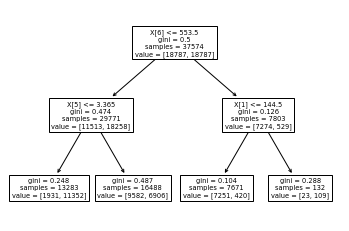

In [217]:
from sklearn.tree import plot_tree

plot_tree(dtc)

### Random Forest

In [190]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=2, random_state=42)
rfc.fit(X_balanced, y_balanced)

train_score = rfc.score(X_balanced, y_balanced)
test_score = rfc.score(X_test, y_test)

print(f'train score: {train_score}')
print(f'test score: {test_score}')

train score: 0.7795550114440837
test score: 0.6234793187347932


              precision    recall  f1-score   support

           0       1.00      0.61      0.75      4697
           1       0.11      0.97      0.20       235

    accuracy                           0.62      4932
   macro avg       0.55      0.79      0.48      4932
weighted avg       0.96      0.62      0.73      4932



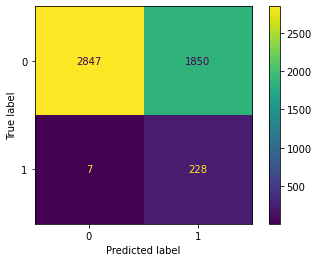

In [218]:
metrics(rfc)

# GridSearch

#### Random Forest

In [149]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

params = {
    'n_estimators': [50, 100],
    'min_samples_split': [10, 50],
    'max_depth': [10, 25],
    'min_samples_leaf': [2,10]
    

}

clf = RandomForestClassifier(random_state=42)

model = GridSearchCV(estimator = clf, param_grid=params, scoring='precision')

model.fit(X_balanced, y_balanced)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 25], 'min_samples_leaf': [2, 10],
                         'min_samples_split': [5, 10],
                         'n_estimators': [50, 100]},
             scoring='precision')

In [214]:
import joblib

joblib.dump(model, './PickledModels/model_grid_randomForest.pkl')

['./PickledModels/model_grid_randomForest.pkl']

In [150]:
train_score = model.score(X_balanced, y_balanced)
test_score = model.score(X_test, y_test)

print(f'train score: {train_score}')
print(f'test score: {test_score}')
print(model.best_params_)

train score: 0.988217347851244
test score: 0.42857142857142855
{'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4697
           1       0.43      0.46      0.44       235

    accuracy                           0.95      4932
   macro avg       0.70      0.71      0.71      4932
weighted avg       0.95      0.95      0.95      4932



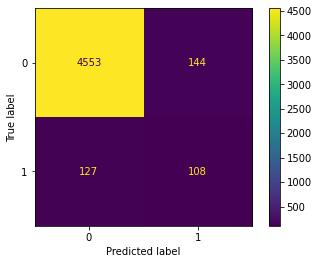

In [219]:
rfc_best = model.best_estimator_

metrics(rfc_best)

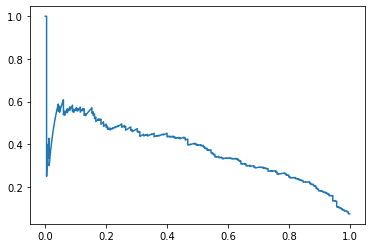

In [223]:
from sklearn.metrics import precision_recall_curve

y_proba = rfc_best.predict_proba(X_test)[:, 1]
precision, recall, treshold = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision)

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

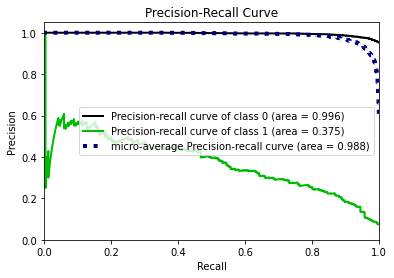

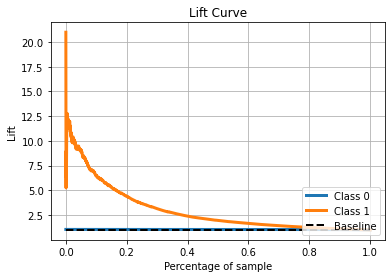

In [224]:
import scikitplot as skplt

y_pred_prob = rfc_best.predict_proba(X_test)
skplt.metrics.plot_precision_recall(y_test, y_pred_prob)
skplt.metrics.plot_lift_curve(y_test, y_pred_prob)

In [222]:
# Feature importancees

feat_imp = pd.Series(rfc.feature_importances_, index=X_test.columns)
feat_imp.sort_values(ascending=False)[0:10]

Thickness                           0.137068
c                                   0.131027
nb                                  0.110002
mn                                  0.106751
Hardness_2                          0.083668
Hardness_1                          0.079491
si                                  0.056232
Temperature after finishing mill    0.045341
n                                   0.039848
s                                   0.032395
dtype: float64

What happens is we move the treshold?

In [198]:
max_prec = precision[:-70].max()
tr = treshold[list(precision).index(max_prec)]
y_pred_new = list(map(lambda x: 1 if x>0.67 else 0, list(y_proba)))
print(sum(y_pred_new)/len(y_pred_new))
print(confusion_matrix(y_test, y_pred_new))
print(classification_report(y_test,y_pred_new))

0.007907542579075427
[[4684   13]
 [ 209   26]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4697
           1       0.67      0.11      0.19       235

    accuracy                           0.95      4932
   macro avg       0.81      0.55      0.58      4932
weighted avg       0.94      0.95      0.94      4932

